In [2]:
#Installing required libraries
!pip install cartopy


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 73.1 MB/s eta 0:00:00


In [3]:
#Importing necessary modules
import requests
import time
import datetime
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import pandas as pd
from pyspark.sql import SparkSession


In [4]:
#Creating a Spark session
spark_session = SparkSession.builder.appName("Tracking_NASA_ISS_Satellite").getOrCreate()


In [5]:
#Defining a function to get ISS location from the API
def get_iss_coordinates():
    api_url = "http://api.open-notify.org/iss-now.json"
    try:
        api_response = requests.get(api_url, timeout=10)
        iss_data = api_response.json()

        longitude = float(iss_data["iss_position"]["longitude"])
        latitude = float(iss_data["iss_position"]["latitude"])
        timestamp_utc = datetime.datetime.utcnow().strftime('%Y-%m-%d %H:%M:%S')

        print(f" ISS Location at {timestamp_utc}: Longitude={longitude}, Latitude={latitude}")
        return (timestamp_utc, longitude, latitude)
    except Exception as error:
        print("Failed to fetch ISS location:", error)
        return None


In [6]:
#Collecting satellite data every 5 seconds for 1 hour
iss_trajectory_data = []

start_time_seconds = time.time()
duration_in_seconds = 3600  # 1 hour = 3600 seconds
end_time_seconds = start_time_seconds + duration_in_seconds

print(" Starting 1-hour ISS satellite tracking...")
while time.time() < end_time_seconds:
    coordinate_data = get_iss_coordinates()
    if coordinate_data:
        iss_trajectory_data.append(coordinate_data)
    time.sleep(5)  # Interval of 5 seconds
print("Tracking complete.")


 Starting 1-hour ISS satellite tracking...
 ISS Location at 2025-04-15 16:06:48: Longitude=-40.2617, Latitude=33.1538
Failed to fetch ISS location: HTTPConnectionPool(host='api.open-notify.org', port=80): Max retries exceeded with url: /iss-now.json (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0x7e08ffb66510>, 'Connection to api.open-notify.org timed out. (connect timeout=10)'))
 ISS Location at 2025-04-15 16:07:08: Longitude=-39.2095, Latitude=32.2791
 ISS Location at 2025-04-15 16:07:20: Longitude=-38.5888, Latitude=31.7495
 ISS Location at 2025-04-15 16:07:33: Longitude=-37.9504, Latitude=31.1941
 ISS Location at 2025-04-15 16:07:39: Longitude=-37.6468, Latitude=30.9262
 ISS Location at 2025-04-15 16:07:44: Longitude=-37.3953, Latitude=30.7024
 ISS Location at 2025-04-15 16:07:49: Longitude=-37.145, Latitude=30.478
 ISS Location at 2025-04-15 16:07:54: Longitude=-36.896, Latitude=30.253
Failed to fetch ISS location: HTTPConnectionPool(host='api.open-no

In [7]:
#Converting the trajectory data to a Spark DataFrame
trajectory_dataframe_pandas = pd.DataFrame(
    iss_trajectory_data, columns=["timestamp_utc", "longitude", "latitude"]
)

trajectory_dataframe_spark = spark_session.createDataFrame(trajectory_dataframe_pandas)
trajectory_dataframe_spark.show(5)


+-------------------+---------+--------+
|      timestamp_utc|longitude|latitude|
+-------------------+---------+--------+
|2025-04-15 16:06:48| -40.2617| 33.1538|
|2025-04-15 16:07:08| -39.2095| 32.2791|
|2025-04-15 16:07:20| -38.5888| 31.7495|
|2025-04-15 16:07:33| -37.9504| 31.1941|
|2025-04-15 16:07:39| -37.6468| 30.9262|
+-------------------+---------+--------+
only showing top 5 rows



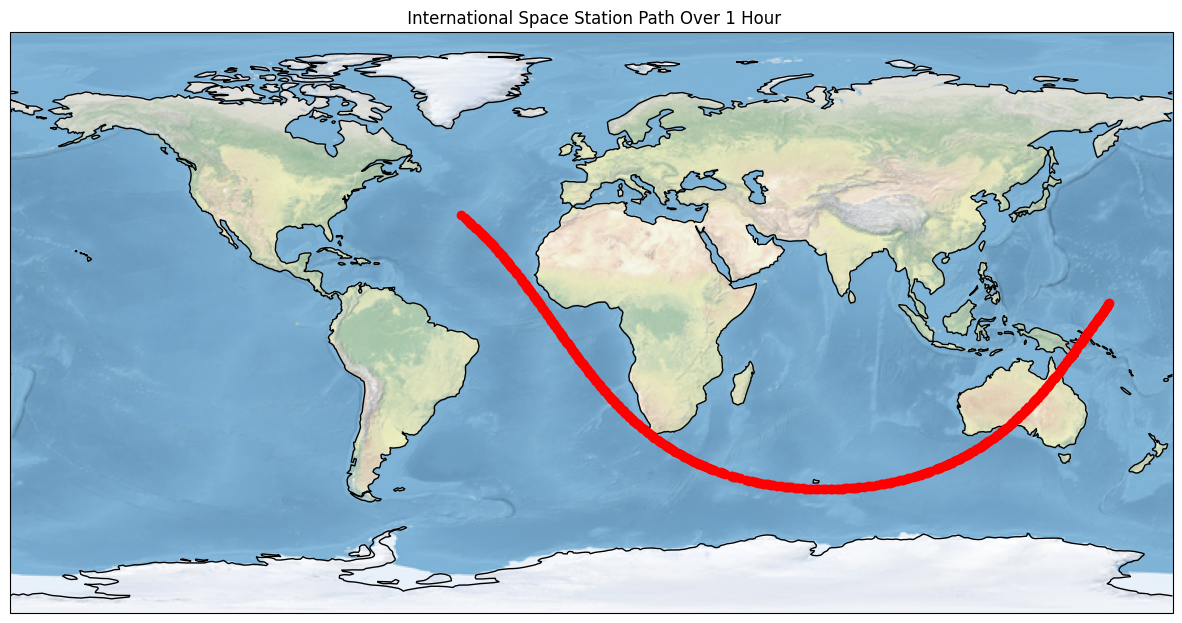

In [9]:
#Plotting the ISS trajectory on a world map
def draw_iss_path_on_world_map(tracked_coordinates):
    longitudes = [float(lon) for _, lon, _ in tracked_coordinates]
    latitudes = [float(lat) for _, _, lat in tracked_coordinates]

    plt.figure(figsize=(15, 8))
    map_axis = plt.axes(projection=ccrs.PlateCarree())
    map_axis.stock_img()
    map_axis.coastlines()
    map_axis.plot(
        longitudes, latitudes, color='red', linewidth=2, marker='o', transform=ccrs.Geodetic()
    )
    plt.title(" International Space Station Path Over 1 Hour")
    plt.show()

draw_iss_path_on_world_map(iss_trajectory_data)
